#### **Autogen AgentChat --- Going Deeper...!**

1. Multi Modal Conversation   
2. Structured Outputs  
3. Using LangChain Tools  
4. Teams

In [1]:
from io import BytesIO
import requests 
from autogen_agentchat.messages import TextMessage, MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from IPython.display import display, Markdown
from pydantic import BaseModel, Field
from typing import Literal

load_dotenv(override=True)

True

### **Multi Modal Conversation**


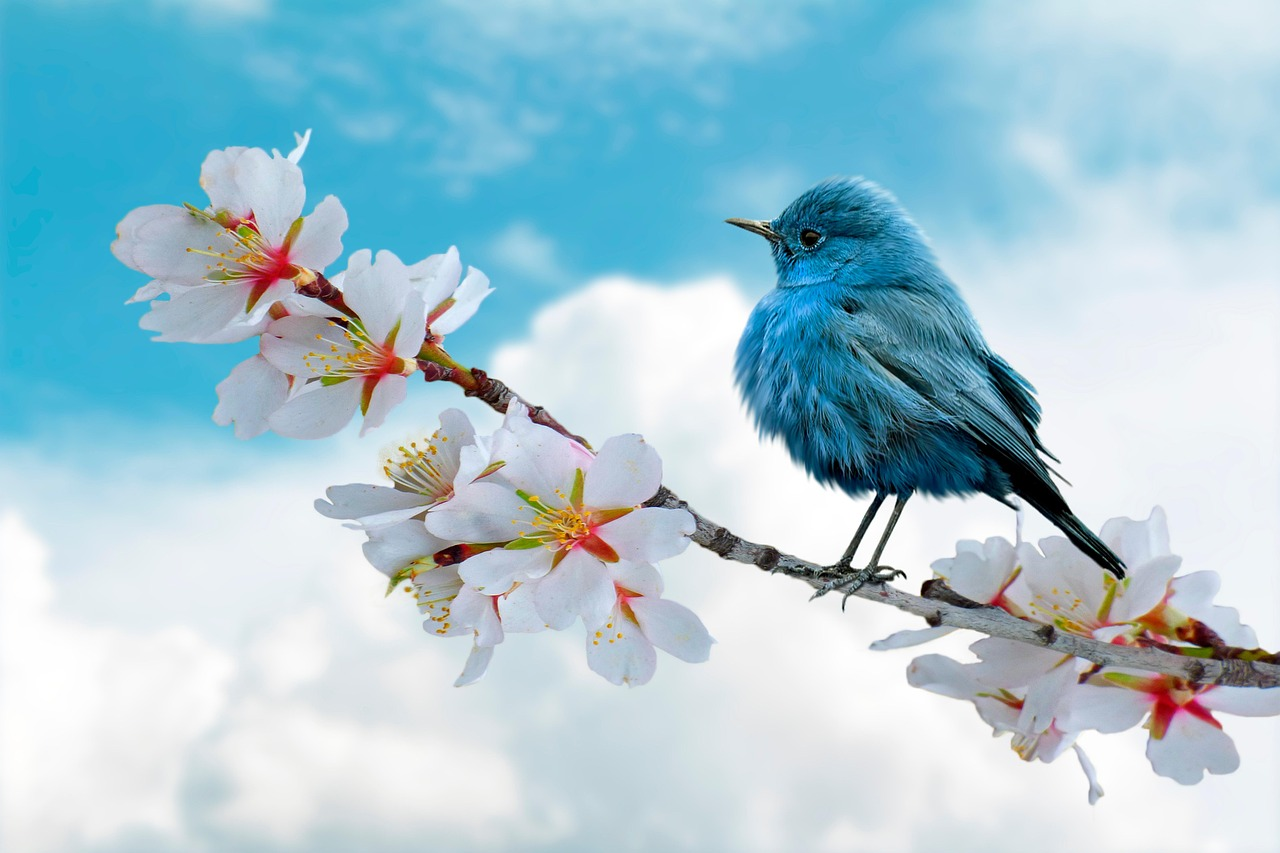

In [4]:
url = "https://cdn.pixabay.com/photo/2024/05/26/10/15/bird-8788491_1280.jpg"

pil_image = Image.open(BytesIO(requests.get(url).content))
img = AGImage(pil_image)
img

AGImage = autogen.agentchat.media.AGImage, a helper class in AutoGen AgentChat

It wraps the PIL.Image object so it can be:

Sent as a message between agents

Rendered in a notebook

Used with multimodal models (like GPT-4o, Gemini, Claude 3)

In [15]:
multi_modal_message = MultiModalMessage(content=["Decribe the content of this image in detail", img], source="User")

In [16]:
model_client = OpenAIChatCompletionClient(model='gpt-4.1-nano')

describer = AssistantAgent(
    name="describer",
    model_client=model_client,
    system_message='You describe images with a sad poetry.'
)

In [17]:
response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
display(Markdown(reply))

Amidst the gentle whisper of a clouded sky, a delicate branch bears blossoms of pure white, their petals soft as dreams, touched with subtle hints of pink at the center. A tiny blue bird perches quietly on this fragile stem, its feathers shimmering like a frozen splash of sky, a fleeting echo of serenity in a fleeting world. Together, they evoke a moment of fragile beauty and silent hope, lost in the vast, indifferent heavens.

### **Structured Outputs!**

Autogen AgentChat makes it easy!

In [18]:
class ImageDescription(BaseModel):
    scene: str = Field(..., description="Briefly, the overall scene of the image.")
    message: str = Field(description="The point that the image is trying to convey.")
    style: str = Field(description="The artistic style of the image")
    orientation: Literal["potrait", "landscape", "square"] = Field(description="The orientation of the image.")

In [19]:
model_client = OpenAIChatCompletionClient(model='gpt-4o-mini')

describer = AssistantAgent(
    name="describer", 
    model_client=model_client,
    system_message="You describe images very well",
    output_content_type=ImageDescription
)

In [20]:
response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content

In [21]:
print(reply)

scene='The image presents a charming scene featuring a vibrant blue bird perched delicately on a slender branch adorned with blossoms.' message='The image conveys a sense of peace and beauty in nature, showcasing the harmony between birds and blooming flowers.' style='The artistic style appears to be realistic with bright colors and clear details, emphasizing the vivid blue of the bird and the softness of the flowers against the sky.' orientation='landscape'


In [22]:
import textwrap
print(f"Scene:\n{textwrap.fill(reply.scene)}\n\n")
print(f"Message:\n{textwrap.fill(reply.message)}\n\n")
print(f"Style:\n{textwrap.fill(reply.style)}\n\n")
print(f"Orientation:\n{textwrap.fill(reply.orientation)}\n\n")

Scene:
The image presents a charming scene featuring a vibrant blue bird
perched delicately on a slender branch adorned with blossoms.


Message:
The image conveys a sense of peace and beauty in nature, showcasing
the harmony between birds and blooming flowers.


Style:
The artistic style appears to be realistic with bright colors and
clear details, emphasizing the vivid blue of the bird and the softness
of the flowers against the sky.


Orientation:
landscape




### **Using LangChain Tools from AutoGen**

In [32]:
# Autogen's wrapper

from autogen_ext.tools.langchain import LangChainToolAdapter

# LangChain's tools

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain.agents import Tool


prompt = """
    Your task is to find a one-way non-stop flight from JFK to LHE in July 2025.
    First search online for promising deals.
    In case you are unable to find a one-way non stop flight, search for other alternatives available.
    Next, write all the deals to a file called flights.md with full details.
    Finally, select the one you think is the best and reply with a short summary.
    Reply with the selected flights only, and only after you have written the details to a file.
"""


serper = GoogleSerperAPIWrapper()
langchain_serper = Tool(
    name = "internet_search",
    func = serper.run,
    description="useful when you need to search the internet."
)
autogen_serper = LangChainToolAdapter(langchain_serper)
autogen_tools=[autogen_serper]

langchain_file_management_tools = FileManagementToolkit(root_dir="sandbox").get_tools()
for tool in langchain_file_management_tools:
    autogen_tools.append(LangChainToolAdapter(tool))

for tool in autogen_tools:
    print(tool.name, tool.description)

internet_search useful when you need to search the internet.
copy_file Create a copy of a file in a specified location
file_delete Delete a file
file_search Recursively search for files in a subdirectory that match the regex pattern
move_file Move or rename a file from one location to another
read_file Read file from disk
write_file Write file to disk
list_directory List files and directories in a specified folder


In [33]:
# finally the agent

model_client = OpenAIChatCompletionClient(model='gpt-4.1-nano')
agent = AssistantAgent(
    name="searcher",
    model_client=model_client,
    tools=autogen_tools,
    reflect_on_tool_use=True,
)

message = TextMessage(content=prompt, source="user")
result = await agent.on_messages([message], cancellation_token=CancellationToken())

for message in result.inner_messages:
    print(message.content)

display(Markdown(result.chat_message.content))

[FunctionCall(id='call_MnBsyc5v2QnSkF3dJnqwuMiX', arguments='{"query":"one-way non-stop flight from JFK to LHE in July 2025"}', name='internet_search')]
[FunctionExecutionResult(content='Cheap Flights from New York (JFK) to Lahore (LHE) start at $492 for one-way and $914 for round trip. Earn your airline miles on top of our rewards! Find flights. Cheapest one-way flight, $492. Saudia1 stop24 hrAug 28. The cheapest one-way flight from New York to Lahore is currently $492. Find flights. Need to get from New York to Lahore? With fares from , we offer a great choice of food, drinks and onboard entertainment & WiFi. Flights from New York John F. Kennedy (JFK) to Lahore (LHE) Economy Class from USD 1023* Return One way Multicity Log in to book Classic Rewards 1 stop. from $364 · Lahore.$389 per passenger.Departing Fri, Oct 3.One-way flight with Norse Atlantic Airways (UK).Outbound indirect flight with Norse Atlantic ... New York (JFK)to. Lahore (LHE). 25 Jul 2025 - 25 Sep 2025. From. USD1,05

Since a direct non-stop flight from JFK to LHE in July 2025 does not appear to be available, I will look for the best alternatives, including flights with one-stop connections or other options. I will now compile all relevant details into the file "flights.md".

In [34]:
message = TextMessage(content="OK, proceed", source="user")

response = await agent.on_messages([message], cancellation_token=CancellationToken())
for inner_message in response.inner_messages:
    print(inner_message.content)

display(Markdown(response.chat_message.content))

[FunctionCall(id='call_AQ6MSenZbsP8Xtjpu5NifFkr', arguments='{"file_path":"flights.md","text":"Flight options from JFK to LHE in July 2025:\\n\\n1. One-stop flights starting at $492 for one-way. Airlines may include Saudia with a 1-stop layover, departing on or around July 2025.\\n2. Other options include flights with airlines like Norse Atlantic Airways, with prices around $1,057 for a one-way trip.\\n3. No direct non-stop flights are available from JFK to LHE in July 2025.\\n\\nPlease review these options for more details and select the best fit."}', name='write_file')]
[FunctionExecutionResult(content='File written successfully to flights.md.', name='write_file', call_id='call_AQ6MSenZbsP8Xtjpu5NifFkr', is_error=False)]


I have compiled the available flight options into the file "flights.md". The best deal appears to be a one-stop flight starting at $492, with other options priced higher. Based on the prices, the most economical choice is the $492 one-stop flight. 

Do you want me to finalize this as the chosen flight, or do you need more details or assistance?

When I passed that second message, i.e. "OK, proceed", as it earlier asked me if it should write the results in 'flight.md', 
I wondered that how can the agent maintain this state information and preserve the context between two different interactions, and here is what i found:


**Agent State:**
Individual agents within AutoGen are stateful. This means they maintain an internal memory of past interactions and information relevant to their role. This includes their conversation history, allowing them to interpret new messages in the context of previous exchanges.  

**Conversation History:**
AutoGen agents maintain a conversation history internally. This history is crucial for maintaining context throughout a multi-agent chat, enabling agents to refer back to previous messages and decisions. When new messages are passed to an agent, they are added to this existing history, not replacing it.

But, this remains for a particular session only.

### **Team Interactions**

In [38]:
from autogen_agentchat.agents import AssistantAgent 
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat

from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool


In [42]:
model_client = OpenAIChatCompletionClient(model='gpt-4.1-nano')

serper = GoogleSerperAPIWrapper()
langchain_serper = Tool(
    name="internet_search",
    func = serper.run,
    description="useful for when you need to search the internet."
)
autogen_serper = LangChainToolAdapter(langchain_serper)

prompt = """Find a one way, non-stop flight from RPR to DEL on 25th July 2025"""

primary_agent = AssistantAgent(
    name="primary",
    model_client=model_client,
    tools=[autogen_serper],
    system_message="You are a helpful AI research assistant who looks for promising deals on flights."
)

evaluation_agent = AssistantAgent(
    name="evaluator",
    model_client = model_client,
    system_message="Provide constructive feedback. Respond with 'APPROVE' when your feedback is addressed."
)


text_termination = TextMentionTermination("APPROVE")

team = RoundRobinGroupChat([primary_agent, evaluation_agent], termination_condition=text_termination, max_turns=10)


In [43]:
result = await team.run(task=prompt)
for message in result.messages:
    print(f"{message.source}:\n{message.content}\n\n")

user:
Find a one way, non-stop flight from RPR to DEL on 25th July 2025


primary:
[FunctionCall(id='call_7GLhhvizWiFRjXFuFwxFeXLr', arguments='{"query": "one way non-stop flight from RPR (Raipur) to DEL (Delhi) on 25th July 2025"}', name='internet_search')]


primary:
[FunctionExecutionResult(content='A: Flight prices from Raipur to Delhi vary, but deals this week show fares starting from ₹4063. Typically, one-way tickets fall within the ₹5,000 to ₹6,500 ... New Delhi.$52 per passenger.Departing Sat, Jul 26.One-way flight with Air India.Outbound direct flight with Air India departing from Raipur on Sat, Jul 26, ... Find flights to New Delhi from $57. Fly from Raipur on IndiGo, Air India and more. Search for New Delhi flights on KAYAK now to find the best deal. Cheap Flights from Raipur (RPR) to Delhi (DEL) start at $56 for one-way and $107 for round trip ... Prices were last updated on July 20 2025 and have not changed ... Raipur to Delhi flight duration, 2 hours (for direct flights) 

### **Introducing MCP!**

Autogen makes it easy to use MCP tools, just like LangChain tools.

In [44]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient 
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools

In [ ]:
# Get the ferch tool from the mcp-server-fetch
fetch_mcp_server = StdioServerParams(command='uvx', args=['mcp-server-fetch'])
fetcher = await mcp_server_tools(fetch_mcp_server)

# Create an agent that can use the fetch tool
model_client = OpenAIChatCompletionClient(model = 'gpt-4o-mini')
agent = AssistantAgent(
    name="fetcher",
    model_client = model_client,
    tools = [fetcher],
    reflect_on_tool_use=True
)

# Let the agent fetch the contect of a url and summaise it.
result = await agent.run(task="Review https://github.com/Jai-Keshav-Sharma?tab=repositories and summarise this guys areas of expertise. Reply in Markdown.")
display(Markdown(result.messages[-1].content))

This fetch tool uses Playwright Browser under the hood in headless mode.

This code is implemented in a python module named: "2_autogen_MCP.py" in the same directory, as Playwright has some event_loop related issues while running it in Notebook